In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
#sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
#import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
df=pd.read_csv('../input/train2016_withy.csv')

In [4]:
df=df.loc[np.random.permutation(df.index)]

In [5]:
testx=df.drop(['parcelid','logerror'],axis=1)[(df.month<=3)]
testy=df['logerror'][(df.month<=3)]
testx.shape,testy.shape

((21541, 95), (21541,))

In [6]:
trainx=df.drop(['parcelid','logerror'],axis=1)[~(df.month<=3)]
trainy=df['logerror'][~(df.month<=3)]
trainx.shape,trainy.shape

((68734, 95), (68734,))

In [7]:
def init_xg():
    if 1:
        import sys
        xgpath='/home/spark/tmp/lib/'
        if xgpath not in sys.path:
            sys.path.insert(0, xgpath)
        import xgboost as xgb
        assert xgb.__file__.startswith(xgpath), xgb.__file__
        return xgb
    else:
        import xgboost as xgb
        return xgb
    

In [8]:
class Trainer():
    def __init__(self):
        self.xgb=init_xg()
    def train(self,trainx,trainy):
        if 0:
            ncol=int(trainx.shape[1]*0.6)
            self.cols=np.random.permutation(trainx.columns)[:ncol]
        else:
            self.cols=trainx.columns
        trainx=trainx[self.cols]
        from sklearn.model_selection import KFold
        from sklearn.utils import resample

        kf = KFold(n_splits=5,shuffle=True)
        models=[]
        for train_index, test_index  in kf.split(trainx):
            x_train, y_train, x_valid, y_valid = trainx.iloc[train_index],\
                trainy.iloc[train_index], trainx.iloc[test_index], trainy.iloc[test_index]
            if 0:
                idx=resample(range(len(x_train)))
                x_train=x_train.iloc[idx]
                y_train=y_train.iloc[idx]                
            models.append(self.train_once(x_train, y_train, x_valid, y_valid))
        self.models=models
        return self
    def train_once(self,x_train, y_train, x_valid, y_valid):
        xgb=self.xgb
        print('Building DMatrix...')
        d_train = xgb.DMatrix(x_train, label=y_train)
        d_valid = xgb.DMatrix(x_valid, label=y_valid)
        ymedian=np.median(y_train)
        print('Training ...')

        params = {}
        params['eta'] = 0.01
        params['objective'] = 'reg:smoothl1'
        #params['objective'] = 'reg:linear'
        params['subsample']=0.8
        params['colsample_bytree']=0.8
        params['eval_metric'] = 'mae'
        params['max_depth'] = 8
        params['silent'] = 1
        params['gamma'] = 2
        params['base_score'] = ymedian
        params['min_child_weight']=50
        params['tree_method']='hist'

        watchlist = [(d_train, 'train')] + [ (d_valid, 'valid')]
        clf = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=30, verbose_eval=10)
        return clf    
    def predict(self,x_test):
        x_test=x_test[self.cols]
        lst=[]
        d_test = self.xgb.DMatrix(x_test)
        for clf in self.models:
            p_test = clf.predict(d_test)
            lst.append(p_test)
        pred=reduce(lambda u,v:u+v, lst)/len(lst)
        return pred
    def score(self,x_test,y_test):
        pred=self.predict(x_test)
        return np.mean(np.abs(y_test-pred))

# spark

In [9]:
import findspark
findspark.init()

In [10]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','10G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local[6]")

In [11]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [12]:
trainXY=sc.broadcast((trainx,trainy))
testXY=sc.broadcast((testx,testy))

In [13]:
def f():
    trainer=Trainer()
    trainer.train(trainXY.value[0],trainXY.value[1])
    a=[float(u) for u in trainer.predict(testXY.value[0])]
    return zip(range(len(a)),a)

In [14]:
N=1000
pred0=sc.parallelize(range(N)).map(lambda u: f()).flatMap(lambda u:u).groupByKey().map(lambda u: (u[0],list(u[1]))).cache()
%time pred0.count()

CPU times: user 108 ms, sys: 69.5 ms, total: 177 ms
Wall time: 14min 25s


21541

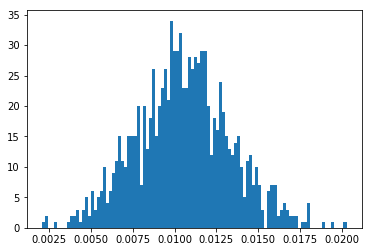

In [15]:
u=pred0.take(78)[-1][1]
plt.hist(u,bins=100);

In [16]:
np.mean(u)-np.median(u)

5.9528543381020399e-05

In [17]:
pred=pred0.map(lambda u: (u[0],np.mean(u[1]))).sortByKey().map(lambda u: u[1]).collect()

In [18]:
np.mean(np.abs(pred-testy))

0.07254400790409345

In [19]:
pred=pred0.map(lambda u: (u[0],np.median(u[1]))).sortByKey().map(lambda u: u[1]).collect()

In [20]:
np.mean(np.abs(pred-testy))

0.07254417444818032

In [24]:
pred0.first()

(0,
 [0.018100367859005928,
  0.0189910177141428,
  0.02076936885714531,
  0.01634138822555542,
  0.014788891188800335,
  0.021764490753412247,
  0.01832699403166771,
  0.01739390566945076,
  0.020231246948242188,
  0.019412219524383545])

In [17]:
np.mean(np.abs(pred-testy))

0.07244397703543873

In [18]:
np.mean(np.abs(testy)),np.mean(np.abs(testy-np.median(testy)))

(0.0738268371941866, 0.07352053757949817)